/home/nkachappilly/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


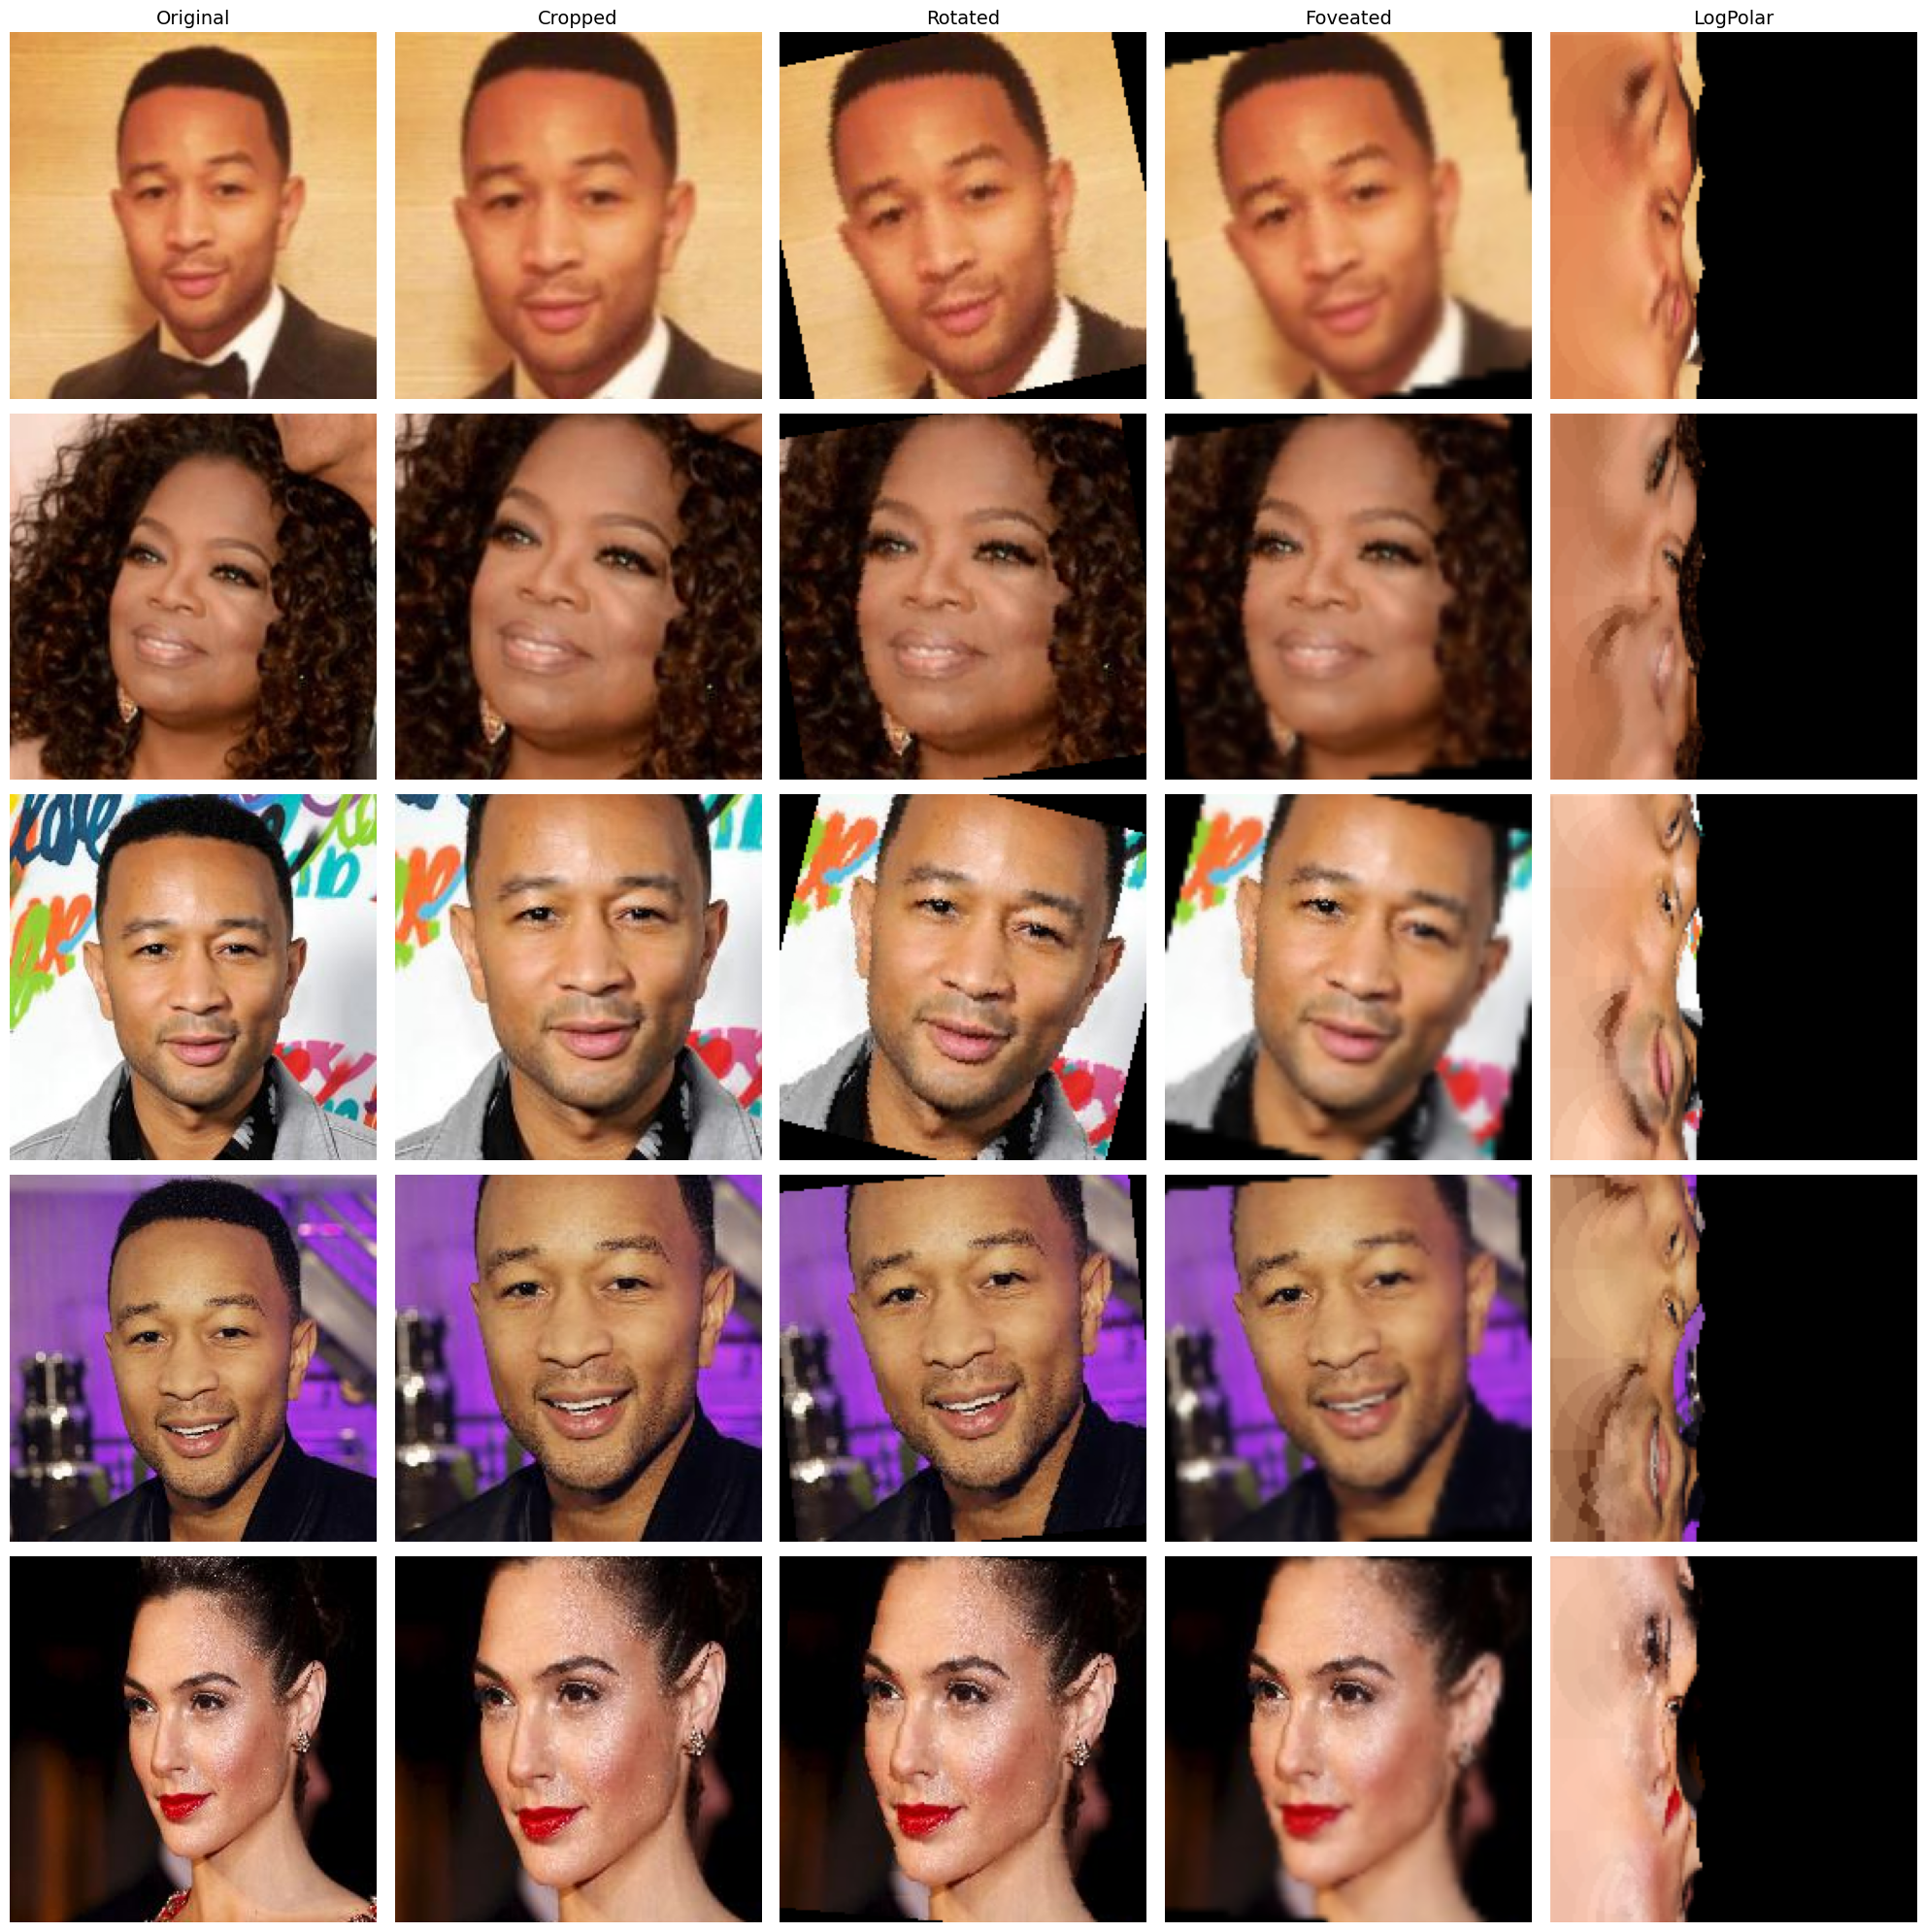

In [1]:
import matplotlib.pyplot as plt
import yaml
import random
import torch
import torchvision.transforms.functional as TF

from utils import *
from pipeline import build_transform_pipeline
from transformations import *
from pipeline import *

# ------------------------------------------------------------------------
# Configuration
# ------------------------------------------------------------------------

dataset_name = "faces"
identity_count = 4
split = "test"

# Load the config
with open('config.yaml', 'r') as f:
    config = yaml.safe_load(f)

# Create each transformation module separately
cropper = RandomCropper(crop_scale=config['params']['crop_scale'])
rotator = RandomRotator(degrees=config['params']['rotation_degrees'])
foveater = Foveater(
    crop_size=config['params']['crop_size'],
    sigma=config['params']['sigma'],
    prNum=config['params']['prNum']
)

logpolar = LogPolarTransformer(
    input_shape=(config['params']['crop_size'], config['params']['crop_size']),
    output_shape=tuple(config['params']['logpolar_output_shape'])
)

# Load dataset WITHOUT transform
ds = load_dataset(
    dataset=dataset_name,
    identity=identity_count,
    task=split,
    transform=None  # <-- important
)

# ------------------------------------------------------------------------
# Display Example Images with progressive transformation
# ------------------------------------------------------------------------


num_samples = 5  
indices = random.sample(range(len(ds)), num_samples)

fig, axes = plt.subplots(num_samples, 5, figsize=(20, 4 * num_samples))  # 5 columns: Original, Cropped, Rotated, Foveated, LogPolar

for row_idx, idx in enumerate(indices):
    crops, label = ds[idx]  # crops is a list of 4 PIL images
    img = crops[0]

    if not isinstance(img, torch.Tensor):
        img = TF.to_tensor(img)

    # Step 1: Original
    img_orig = img.clone()

    # Step 2: Cropped
    img_pil = TF.to_pil_image(img_orig)
    cropped_list = cropper(img_pil)
    img_cropped = cropped_list[2]
    if not isinstance(img_cropped, torch.Tensor):
        img_cropped = TF.to_tensor(img_cropped)

    # Step 3: Rotated
    img_rotated = rotator(img_cropped)
    if not isinstance(img_rotated, torch.Tensor):
        img_rotated = TF.to_tensor(img_rotated)

    # Step 4: Foveated
    img_foveated = foveater(img_rotated)

    # Step 5: LogPolar
    img_logpolar = logpolar(img_foveated)

    # Collect all versions for easy plotting
    imgs = [img_orig, img_cropped, img_rotated, img_foveated, img_logpolar]
    titles = ["Original", "Cropped", "Rotated", "Foveated", "LogPolar"]

    # Plot in a row
    for col_idx, (im, title) in enumerate(zip(imgs, titles)):
        ax = axes[row_idx, col_idx] if num_samples > 1 else axes[col_idx]
        im_show = im.permute(1, 2, 0).cpu().numpy().clip(0, 1)
        ax.imshow(im_show)
        if row_idx == 0:
            ax.set_title(title, fontsize=14)
        if col_idx == 0:
            ax.set_ylabel(f"Label: {label}", fontsize=12)
        ax.axis('off')

plt.tight_layout()
plt.show()


In [3]:
from utils import *
from pipeline import build_transform_pipeline
import yaml
import random
import matplotlib.pyplot as plt
from transformations import *
from pipeline import *

# ------------------------------------------------------------------------
# Configuration
# ------------------------------------------------------------------------

# Choose the dataset to load:
#   - "celeb":  only supports splits "train" and "test"
#   - "faces":  supports identity counts {4, 8, 16, 32, 64, 128}
#               and splits "train", "valid", "test"
dataset_name   = "faces"  # Options: "celeb", "faces"
identity_count = 4        # Only used when dataset_name == "faces"
split          = "test"   # For "celeb": {"train", "test"};
                            # for "faces": {"train", "valid", "test"}

# ------------------------------------------------------------------------
# Build Transformation Pipeline
# ------------------------------------------------------------------------

# Load the config
with open('config.yaml', 'r') as f:
    config = yaml.safe_load(f)

# Build the transform pipeline
train_transform = build_transform_pipeline(config)

# ------------------------------------------------------------------------
# Load dataset
# ------------------------------------------------------------------------

# load_dataset parameters:
#   dataset  : str   -> which dataset to load ("celeb" or "faces")
#   identity : int   -> number of distinct identities (only for "faces")
#   task     : str   -> which split to load ("train", "valid", "test")
#   transform: nn.Sequential -> transformations to apply to the dataset
ds = load_dataset(
    dataset=dataset_name,
    identity=identity_count,
    task=split,
    transform=None
)

# ------------------------------------------------------------------------
# Display Example Images
# ------------------------------------------------------------------------

# num_samples = 5  
# indices = random.sample(range(len(ds)), num_samples)

# fig, axes = plt.subplots(num_samples, 4, figsize=(12, 10))
# for row_idx, idx in enumerate(indices):
#     crops, label = ds[idx]  # crops is a list of 4 images
#     #print(f"Sample {idx}: Number of crops = {len(crops)}")  
#     for col_idx in range(4):
#         if col_idx < len(crops):  # Check if the crop exists
#             ax = axes[row_idx, col_idx]
#             img = crops[col_idx]
#             if not isinstance(img, torch.Tensor):   
#                 img = TF.to_tensor(img) # Converts PIL Image to Tensor
#             img = img.permute(1, 2, 0)  # (C, H, W) -> (H, W, C) for matplotlib
#             ax.imshow(img)
#             if col_idx == 0:
#                 ax.set_ylabel(f"Label: {label}", size=10)
#             ax.axis('off')
#         else:
#             axes[row_idx, col_idx].axis('off')  
#             axes[row_idx, col_idx].text(0.5, 0.5, "No crop", ha="center", va="center", fontsize=12)

# plt.tight_layout()
# plt.savefig("sample_crops.png")
# print("Saved figure to sample_crops.png!")
